In [19]:
%reload_ext autoreload
%autoreload 2

from lib.basis import construct_rotation_matrix
from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MultiBasisDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506081653_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506081653_0


In [20]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        shape = (self.n_visible, self.n_hidden)
        self.A_pha = self.param('A_pha', nn.initializers.normal(0.01), shape)
        self.omega_pha = self.param('omega_pha', nn.initializers.normal(0.1), shape)
        self.phi_pha = self.param('phi_pha', nn.initializers.normal(0.1), shape)

        self.b = self.param('b', nn.initializers.zeros, (self.n_visible,))
        self.c = self.param('c', nn.initializers.zeros, (self.n_hidden,))

    def _sine_weights(self, v: jnp.ndarray) -> jnp.ndarray:
         # v shape: (batch, n_visible)
        v_expanded = v[:, :, None]  # (batch, n_visible, 1)
        act = self.omega_pha * v_expanded + self.phi_pha  # (batch, n_visible, n_hidden)
        sin_terms = self.A_pha * jnp.sin(act)
        return jnp.sum(sin_terms, axis=1)

    def _free_energy_amp(self, v):
        # those weights need to be as they have been trained
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        # the phase part is computed using the sine weights (inspired from Kolmogorov Arnold Network weights)
        pre_sigmoid = self._sine_weights(v) + self.c
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(pre_sigmoid), axis=-1)

    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)

    @staticmethod
    def rotated_log_prob(rotation_weights, free_energy_lambda, free_energy_mu):
        # weights are stable known values and the phase part is bounded by +-1. We do log_sum_exp only the real part

        computational_log_magnitudes = -0.5 * free_energy_lambda
        computational_phases = -0.5j * free_energy_mu

        max_computational_log_magnitude = jnp.max(computational_log_magnitudes)

        scaled_computational_amplitudes = jnp.exp(computational_log_magnitudes - max_computational_log_magnitude + computational_phases)

        scaled_measurement_amplitude = jnp.vdot(rotation_weights, scaled_computational_amplitudes)

        log_measurement_amplitude = max_computational_log_magnitude + jnp.log(jnp.abs(scaled_measurement_amplitude) + 1e-30)
        return 2 * log_measurement_amplitude


    def __call__(self, measurement_tuple: Tuple) -> jnp.ndarray:
        measurement, basis = measurement_tuple

        local_indices = jnp.array(jnp.nonzero(basis != 0, size=2, fill_value=-1)[0])

        # get the free energies for all computational basis vectors to construct the full state vector
        local_rotation_matrix = construct_rotation_matrix(basis[local_indices])

        # for outcome 00 we pick first row, for 01 second row, etc.
        local_rotation_weights = local_rotation_matrix[bitstring_to_int(measurement[local_indices])]

        # amplitudes mismatching with our Z measurements are 0. There are only 4 remaining amplitudes with the local variations
        local_measurement_combos = jnp.array([[0,0], [0,1], [1,0], [1,1]], dtype=measurement.dtype)
        local_computational_basis_vectors = jnp.tile(measurement, (4, 1)).at[:, local_indices].set(local_measurement_combos)  # (4, n)

        local_free_energy_lambda = self._free_energy_amp(local_computational_basis_vectors)
        local_free_energy_mu = self._free_energy_pha(local_computational_basis_vectors)

        rotated_log_prob = self.rotated_log_prob(local_rotation_weights, local_free_energy_lambda, local_free_energy_mu)
        return rotated_log_prob

In [21]:
def full_basis_loss(
        params: PyTree,
        apply_fn: Callable,
        amp_vars: Dict[str, jnp.ndarray],
        data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:

    basis_measurements, bases = data_tuple

    single_sample_loss = lambda m, b: apply_fn({'params': params, 'amp': amp_vars}, (m, b))
    single_basis_loss = lambda ms, b: jnp.mean(jax.vmap(lambda m: single_sample_loss(m, b))(ms))

    return -jnp.sum(jax.vmap(lambda ms, b: single_basis_loss(ms, b))(basis_measurements, bases))


@jax.jit
def train_step_sgd(state: TrainState, amp_vars: dict, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: full_basis_loss(params, state.apply_fn, amp_vars, data_tuple)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[str, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:
            state, loss = train_step_sgd(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(loss=avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f}")

    return state, metrics

In [22]:
data_dict = load_measurements(data_dir, "w_*.txt")

keys_pha = [k for k in data_dict if 'Z' in k and re.search(r'[XY]', k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [23]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [34]:
batch_size    = 6400
visible_units = 8
hidden_units  = 24
num_epochs    = 1000
init_lr       = 1e-3
weight_decay  = 1e-5

key = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_meas  = jnp.zeros((visible_units,), dtype=jnp.float32)
dummy_basis = jnp.zeros((visible_units,), dtype=jnp.int8)

vars_pha = model_pha.init(key, (dummy_meas, dummy_basis))

optim = optax.adamw(init_lr, weight_decay=weight_decay)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=batch_size, basis_encoding={'Z': 0, 'X': 1, 'Y': 2}, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

Epoch 1/1000 │ Loss: -138.7192
Epoch 2/1000 │ Loss: -139.0000
Epoch 3/1000 │ Loss: -139.1288
Epoch 4/1000 │ Loss: -139.2094
Epoch 5/1000 │ Loss: -139.2681
Epoch 6/1000 │ Loss: -139.3144
Epoch 7/1000 │ Loss: -139.3531
Epoch 8/1000 │ Loss: -139.3865
Epoch 9/1000 │ Loss: -139.4162
Epoch 10/1000 │ Loss: -139.4432
Epoch 11/1000 │ Loss: -139.4681
Epoch 12/1000 │ Loss: -139.4913
Epoch 13/1000 │ Loss: -139.5132
Epoch 14/1000 │ Loss: -139.5341
Epoch 15/1000 │ Loss: -139.5541
Epoch 16/1000 │ Loss: -139.5733
Epoch 17/1000 │ Loss: -139.5921
Epoch 18/1000 │ Loss: -139.6102
Epoch 19/1000 │ Loss: -139.6281
Epoch 20/1000 │ Loss: -139.6455
Epoch 21/1000 │ Loss: -139.6627
Epoch 22/1000 │ Loss: -139.6797
Epoch 23/1000 │ Loss: -139.6964
Epoch 24/1000 │ Loss: -139.7130
Epoch 25/1000 │ Loss: -139.7294
Epoch 26/1000 │ Loss: -139.7458
Epoch 27/1000 │ Loss: -139.7620
Epoch 28/1000 │ Loss: -139.7782
Epoch 29/1000 │ Loss: -139.7943
Epoch 30/1000 │ Loss: -139.8103
Epoch 31/1000 │ Loss: -139.8264
Epoch 32/1000 │ L

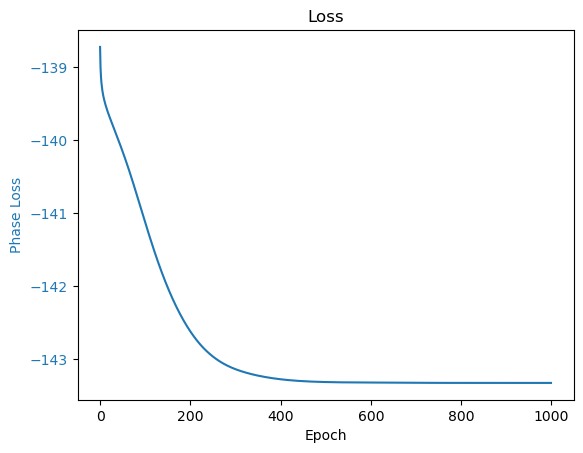

In [35]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [39]:
one_hot_states = jnp.eye(visible_units, dtype=jnp.float32)
one_hot_bitstrings = [''.join('1' if s > 0 else '0' for s in state) for state in one_hot_states]

model_phases_raw = model_pha.apply({"params": state_pha.params, "amp": amp_vars}, one_hot_states, method=model_pha.compute_phase)
model_phases_norm = model_phases_raw - model_phases_raw[-1]
model_phases_wrapped = model_phases_norm % (2 * jnp.pi)

model_phase_tuples = sorted(zip(one_hot_bitstrings, model_phases_raw, model_phases_wrapped), key=lambda x: int(x[0], 2))

for bitstring, phase_raw, phase_wrapped in model_phase_tuples:
    print(f"{bitstring}: {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 40.9998 (raw), 0.6283 (wrapped)
00000010: 40.5705 (raw), 0.1990 (wrapped)
00000100: 37.4912 (raw), 3.4029 (wrapped)
00001000: 35.3216 (raw), 1.2333 (wrapped)
00010000: 37.3401 (raw), 3.2519 (wrapped)
00100000: 37.0472 (raw), 2.9589 (wrapped)
01000000: 32.9170 (raw), 5.1119 (wrapped)
10000000: 31.8224 (raw), 4.0173 (wrapped)


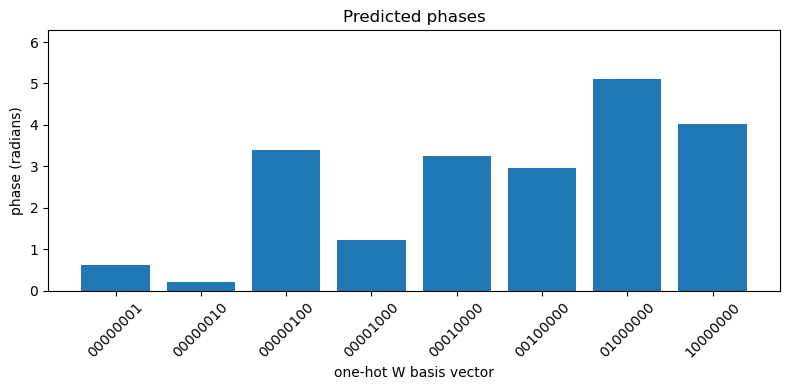

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in model_phase_tuples], [t[2] for t in model_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Predicted phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
w_aug_file_path = Path(data_dir) / f"w_aug_{visible_units}.txt"
w_aug_state_dict = load_state_vector(w_aug_file_path)

phase_offset = np.angle(w_aug_state_dict[one_hot_bitstrings[-1]])

original_phase_tuples = []
for bs in sorted(one_hot_bitstrings, key=lambda x: int(x, 2)):

    amplitude = w_aug_state_dict[bs]
    phase_raw = np.angle(amplitude)  # get raw phase in radians
    phase_norm = phase_raw - phase_offset  # normalize by the last one-hot state
    phase_wrapped = phase_norm % (2 * jnp.pi)

    original_phase_tuples.append((bs, amplitude, phase_raw, phase_wrapped))

for bitstring, amp, phase_raw, phase_wrapped in original_phase_tuples:
    print(f"{bitstring}: {amp:.8f} (ampl), {phase_raw:.4f} (raw), {phase_wrapped:.4f} (wrapped)")

00000001: 0.35348165+0.00712282j (ampl), 0.0201 (raw), 0.0000 (wrapped)
00000010: 0.34222963+0.08876304j (ampl), 0.2538 (raw), 0.2336 (wrapped)
00000100: -0.07679566+0.34511220j (ampl), 1.7898 (raw), 1.7696 (wrapped)
00001000: 0.02867402-0.35238871j (ampl), -1.4896 (raw), 4.7734 (wrapped)
00010000: 0.01964585+0.35300714j (ampl), 1.5152 (raw), 1.4951 (wrapped)
00100000: -0.03371835+0.35194188j (ampl), 1.6663 (raw), 1.6462 (wrapped)
01000000: -0.28657940-0.20705615j (ampl), -2.5159 (raw), 3.7471 (wrapped)
10000000: -0.13468251-0.32689542j (ampl), -1.9616 (raw), 4.3014 (wrapped)


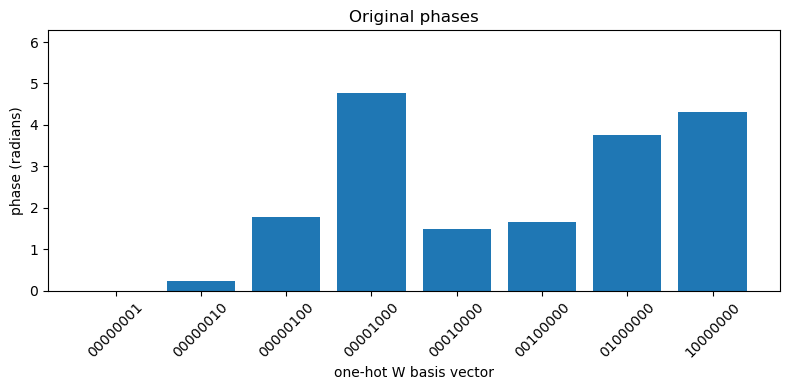

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar([t[0] for t in original_phase_tuples], [t[3] for t in original_phase_tuples])
ax.set_xlabel("one-hot W basis vector")
ax.set_ylabel("phase (radians)")
ax.set_title("Original phases")
ax.set_ylim(0, 2 * jnp.pi)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()